# Pneumonia Detection from Chest X-rays: A Deep Learning Approach


## 1. Medical Background
### 1.1 Introduction- Defining the purpose of this project
This Machine Learning Project aims at understanding and analyzing the results of categorically collected data in the form of X-ray scans. 
- Presenting correlation between the different X-ray image characteristics in order to make the diagnostic process more automated.
- Analyzing general patterns
- Reviewing where in which parts and parameters does each model show weakness resulting in lower preciseness and higher level of misdiagnosis 

### 1.2 Understanding Pneumonia
Pneumonia is an inflammatory condition of the lung affecting the small air sacs (alveoli). When infected:
- Alveoli fill with fluid or pus
- Causes symptoms like difficulty breathing
- Can be life-threatening, especially in:
  - Young children
  - Elderly patients
  - Immunocompromised individuals
Common Symptoms of Pneumonia:
- Cough ( sometimes with phlegm)
- Shortness of breath
- Tiredness
- Raised temperature
- Wheezing
- Body aches and most commonly chest pain
Causes
- Pneumonia is normally caused by an infection, either viral, bacterial or fungal. Additionally this causes inflammation of the alveoli in the lungs.

### 1.3 Diagnosis Through X-rays
Chest X-rays are primary diagnostic tools because they:
- Show infiltrates in infected areas
- Help determine severity and spread
- Allow monitoring of disease progression
- Are cost-effective and widely available

Key radiological features:
- Consolidation (white areas in lung fields)
- Air bronchograms
- Pleural effusions
- Interstitial patterns

In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# < EDA-1: Import required libraries for EDA
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import chi2_contingency, ttest_ind
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# image data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier 
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE


In [2]:
train_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/train"
test_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/test"
val_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/val"

## 2. Technical Implementation
### 2.1 Dataset Overview
Our dataset applied contains:
- Total images: 5216
- Normal cases: 1341
- Pneumonia cases:3875
- Image dimensions: Various (standardized to 224x224)
- Format: Grayscale X-ray images




In [3]:
def get_predictions(model, generator):
    """Utility function to get predictions and classes"""
    predictions = model.predict(generator)
    predicted_classes = (predictions > 0.5).astype(int)
    return predictions, predicted_classes


In [4]:
#  EDA-2: Dataset structure analysis
def analyze_dataset_structure(base_dir):
    dataset_info = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        if os.path.exists(split_dir):
            class_counts = {}
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(split_dir, class_name)
                if os.path.exists(class_path):
                    class_counts[class_name] = len(os.listdir(class_path))
            dataset_info[split] = class_counts
    return dataset_info

base_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray"
dataset_info = analyze_dataset_structure(base_dir)

# Create a DataFrame for visualization
df_info = pd.DataFrame(dataset_info).fillna(0)
print("Dataset Distribution:")
print(df_info)

Dataset Distribution:
           train  val  test
NORMAL      1341    8   234
PNEUMONIA   3875    8   390


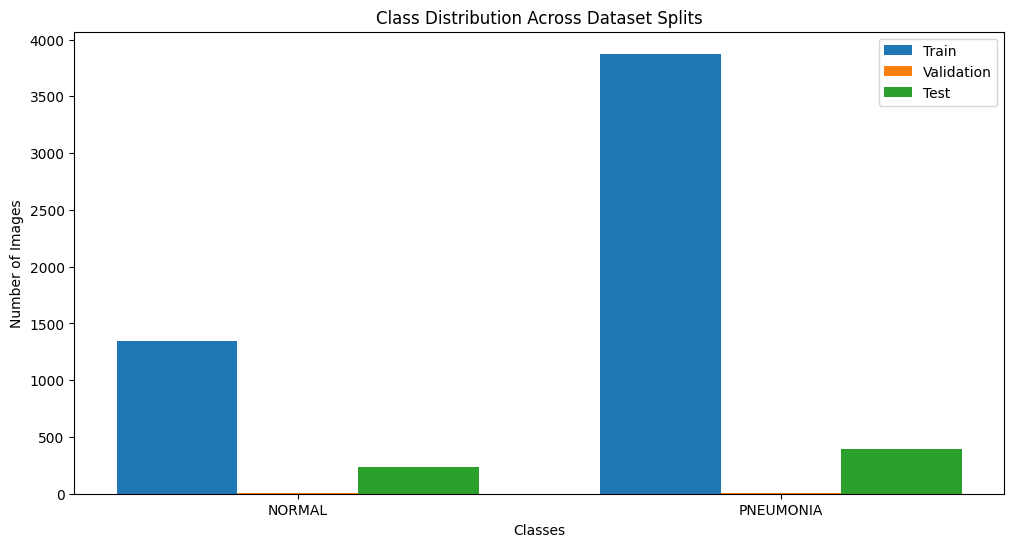

train set - Pneumonia:Normal ratio = 2.89:1
val set - Pneumonia:Normal ratio = 1.00:1
test set - Pneumonia:Normal ratio = 1.67:1


In [5]:
# EDA-3: Visualize class distribution
plt.figure(figsize=(12, 6))

# Plot class distribution for each split
# classes = ['NORMAL', 'PNEUMONIA']
# for i,split in enumerate(df_info.columns):
#     plt.subplot(1, 3, i+1)
x = np.arange(len(df_info.index))
width = 0.25

plt.bar(x - width, df_info['train'], width, label='Train')
plt.bar(x, df_info['val'], width, label='Validation')
plt.bar(x + width, df_info['test'], width, label='Test')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Dataset Splits')
plt.xticks(x, df_info.index)
plt.legend()
plt.show()

# Calculate and display class imbalance ratios
for split in df_info.columns:
    ratio = df_info[split]['PNEUMONIA'] / df_info[split]['NORMAL']
    print(f"{split} set - Pneumonia:Normal ratio = {ratio:.2f}:1")

### 2.2 Data Preprocessing Pipeline
1. Image Standardization:
   - Resize to 224x224 pixels
   - Normalize pixel values to [0,1]
   - Apply contrast enhancement

2. Data Augmentation:
   - Random rotation (±20°)
   - Horizontal flipping
   - Width/height shifts
   - Zoom variation

3. Quality Control:
   - Remove corrupt images
   - Handle class imbalance
   - Validate image integrity

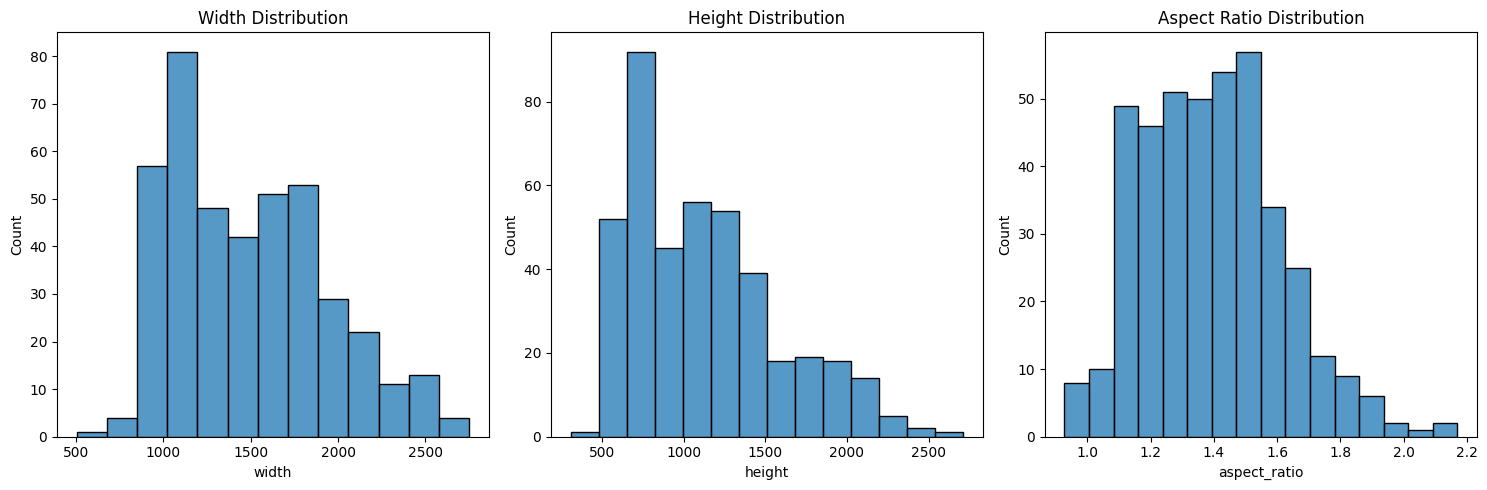


Image Size Statistics:
             width       height  aspect_ratio
count   416.000000   416.000000    416.000000
mean   1494.555288  1125.865385      1.392149
std     446.462953   458.748697      0.215005
min     502.000000   307.000000      0.927755
25%    1095.500000   734.000000      1.226977
50%    1454.000000  1044.000000      1.389842
75%    1793.000000  1400.250000      1.527724
max    2752.000000  2713.000000      2.169231


In [6]:
#  EDA-4: Image size analysis
def analyze_image_sizes(base_dir, max_images=100):
    sizes = []
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_path = os.path.join(split_dir, class_name)
            if os.path.exists(class_path):
                files = os.listdir(class_path)[:max_images]
                for file in files:
                    img_path = os.path.join(class_path, file)
                    with Image.open(img_path) as img:
                        sizes.append({
                            'width': img.size[0],
                            'height': img.size[1],
                            'aspect_ratio': img.size[0]/img.size[1],
                            'split': split,
                            'class': class_name
                        })
    return pd.DataFrame(sizes)

# Analyze image sizes
size_df = analyze_image_sizes(base_dir)

# Plot size distributions
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(data=size_df, x='width')
plt.title('Width Distribution')

plt.subplot(132)
sns.histplot(data=size_df, x='height')
plt.title('Height Distribution')

plt.subplot(133)
sns.histplot(data=size_df, x='aspect_ratio')
plt.title('Aspect Ratio Distribution')

plt.tight_layout()
plt.show()

# Print size statistics
print("\nImage Size Statistics:")
print(size_df[['width', 'height', 'aspect_ratio']].describe())

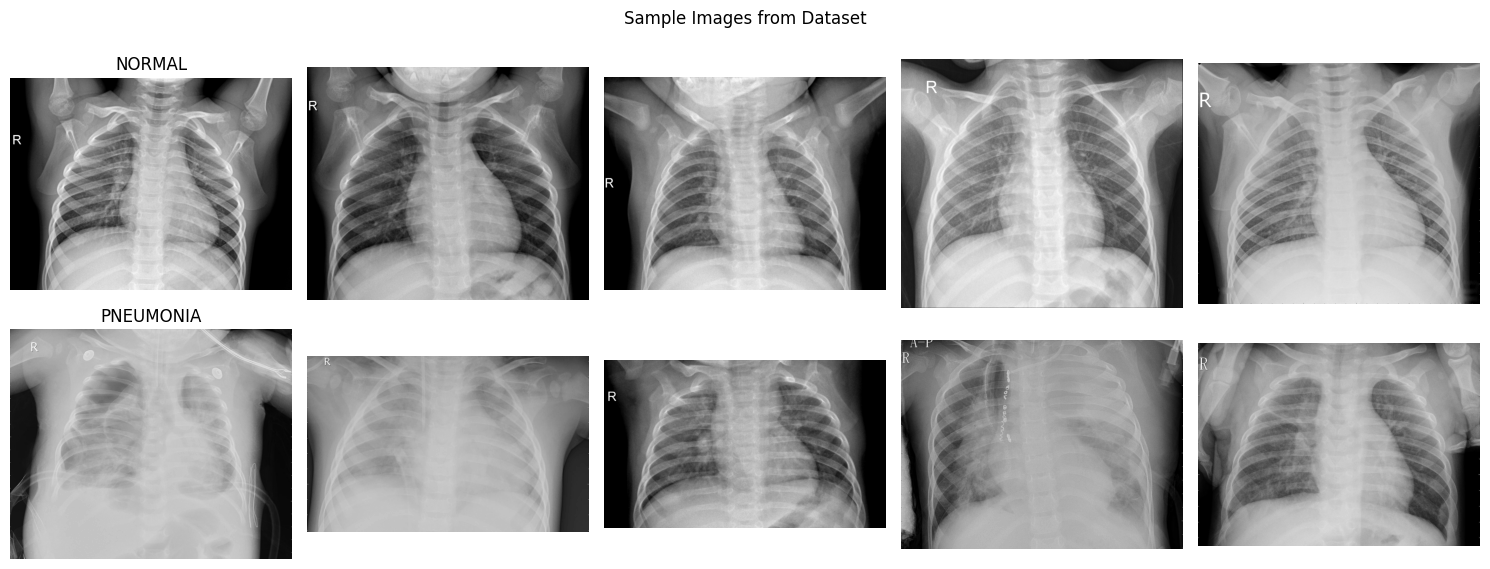

In [7]:
# EDA-5: Sample image visualization
def plot_sample_images(base_dir, n_samples=5):
    plt.figure(figsize=(15, 6))
    
    for idx, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        train_path = os.path.join(base_dir, 'train', class_name)
        images = random.sample(os.listdir(train_path), n_samples)
        
        for i, img_name in enumerate(images):
            img_path = os.path.join(train_path, img_name)
            img = Image.open(img_path)
            
            plt.subplot(2, n_samples, idx * n_samples + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title(f'{class_name}')

    plt.suptitle('Sample Images from Dataset')
    plt.tight_layout()
    plt.show()

plot_sample_images(base_dir)

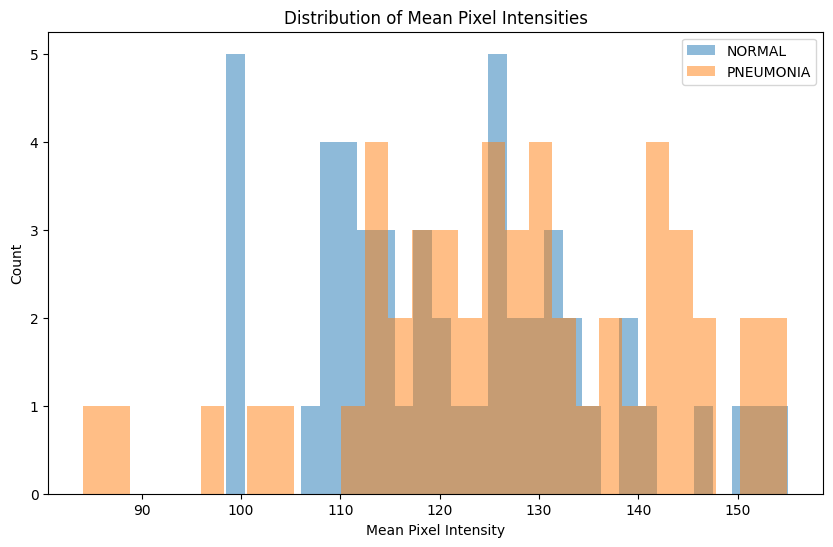


NORMAL class pixel intensity statistics:
count     50.000000
mean     121.680750
std       14.160582
min       98.517012
25%      110.312739
50%      119.432776
75%      131.189424
max      155.064969
dtype: float64

PNEUMONIA class pixel intensity statistics:
count     50.000000
mean     127.010004
std       16.148960
min       84.147135
25%      117.805216
50%      127.377743
75%      140.768321
max      154.927094
dtype: float64


In [8]:
# EDA-6: Pixel  intensity analysis
def analyze_pixel_intensitites(base_dir, n_samples=50):
    intensities = {'NORMAL': [], 'PNEUMONIA': []}
    for class_name in ['NORMAL', 'PNEUMONIA']:
        train_path = os.path.join( base_dir, 'train', class_name)
        images = random.sample(os.listdir(train_path), n_samples)
        for img_name in images:
            img_path = os.path.join(train_path, img_name)
            img = np.array( Image.open(img_path))
            intensities[class_name].append(img.mean())
    plt.figure(figsize=(10,6))
    plt.hist(intensities['NORMAL'], alpha = 0.5, label= 'NORMAL', bins=30)
    plt.hist(intensities['PNEUMONIA'], alpha=0.5, label='PNEUMONIA', bins=30)
    plt.xlabel('Mean Pixel Intensity')
    plt.ylabel('Count')
    plt.title('Distribution of Mean Pixel Intensity')
    plt.ylabel('Count')
    plt.title('Distribution of Mean Pixel Intensities')
    plt.legend()
    plt.show()
    for class_name in intensities:
        print(f"\n{class_name} class pixel intensity statistics:")
        print(pd.Series(intensities[class_name]).describe())
analyze_pixel_intensitites(base_dir)

In [9]:
# As part of the image preprocessing process, Image Padding will be added:
def pad_image(image):
    desired_ratio= 1.0
    current_ratio= image.shape[1]/image.shape[0]
    if current_ratio < desired_ratio:
        padding = int((image.shape[1]/image.shape[0]))
        padded_image= np.pad(image, ((padding, padding), (0,0)), mode='constant')
    else:
        padding = int((image.shape[0]/image.shape[1]))
        padded_image= np.pad(image, ((0,0), (padding, padding)), mode='constant')
    return padded_image


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define path to your training data
train_path = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/train"

# Create generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


Class Weight Balancing:
- Addressing imbalanced dataset(2.89:1 Pneumonia:Normal ratio)
- Penalizing model more heavily for mistakes on underrepresented class
- Helps prevent bias toward majority class



In [11]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS = 3
X_train = []
y_train = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    X_train.extend(batch_x)
    y_train.extend(batch_y)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape data for SMOTE
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape back to image format
X_resampled = X_resampled.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)

# Create new generator with balanced data
train_generator = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled)).batch(32)

In [12]:
def check_data_quality(base_dir):
    issues=[]
    total_files = 0
    corrupted_files = 0
    for split in ['train', 'val', 'test']:
        for class_name in ['NORMAL', 'PNEUMONIA']:
            dir_path = os.path.join(base_dir, split, class_name)
            if os.path.exists(dir_path):
                files = os.listdir(dir_path)
                total_files += len(files)
                for file in files:
                    file_path = os.path.join(dir_path, file)
                    try:
                        with Image.open(file_path) as img:
                            if img.mode not in ['L', 'RGB']:
                                issues.append(f"Usual image mode {img.mode}: {file_path}")
                            if 0 in img.size:
                                issues.append(f"Zero dimension image: {file_path}")
                    except Exception as e:
                        corruptes_files += 1
                        issues.append(f"Corrupted file {file_path}: {str(e)}")
    print(f"Total files: {total_files}")
    print(f"Corrupted files: {corrupted_files}")
    print(f"Issues found: {len(issues)}")
    if len(issues)>0:
        print("\nSample issues:")
        for issue in issues[:5]:
            print(issue)
check_data_quality(base_dir)

Total files: 5856
Corrupted files: 0
Issues found: 0


Successfully processed 200 images


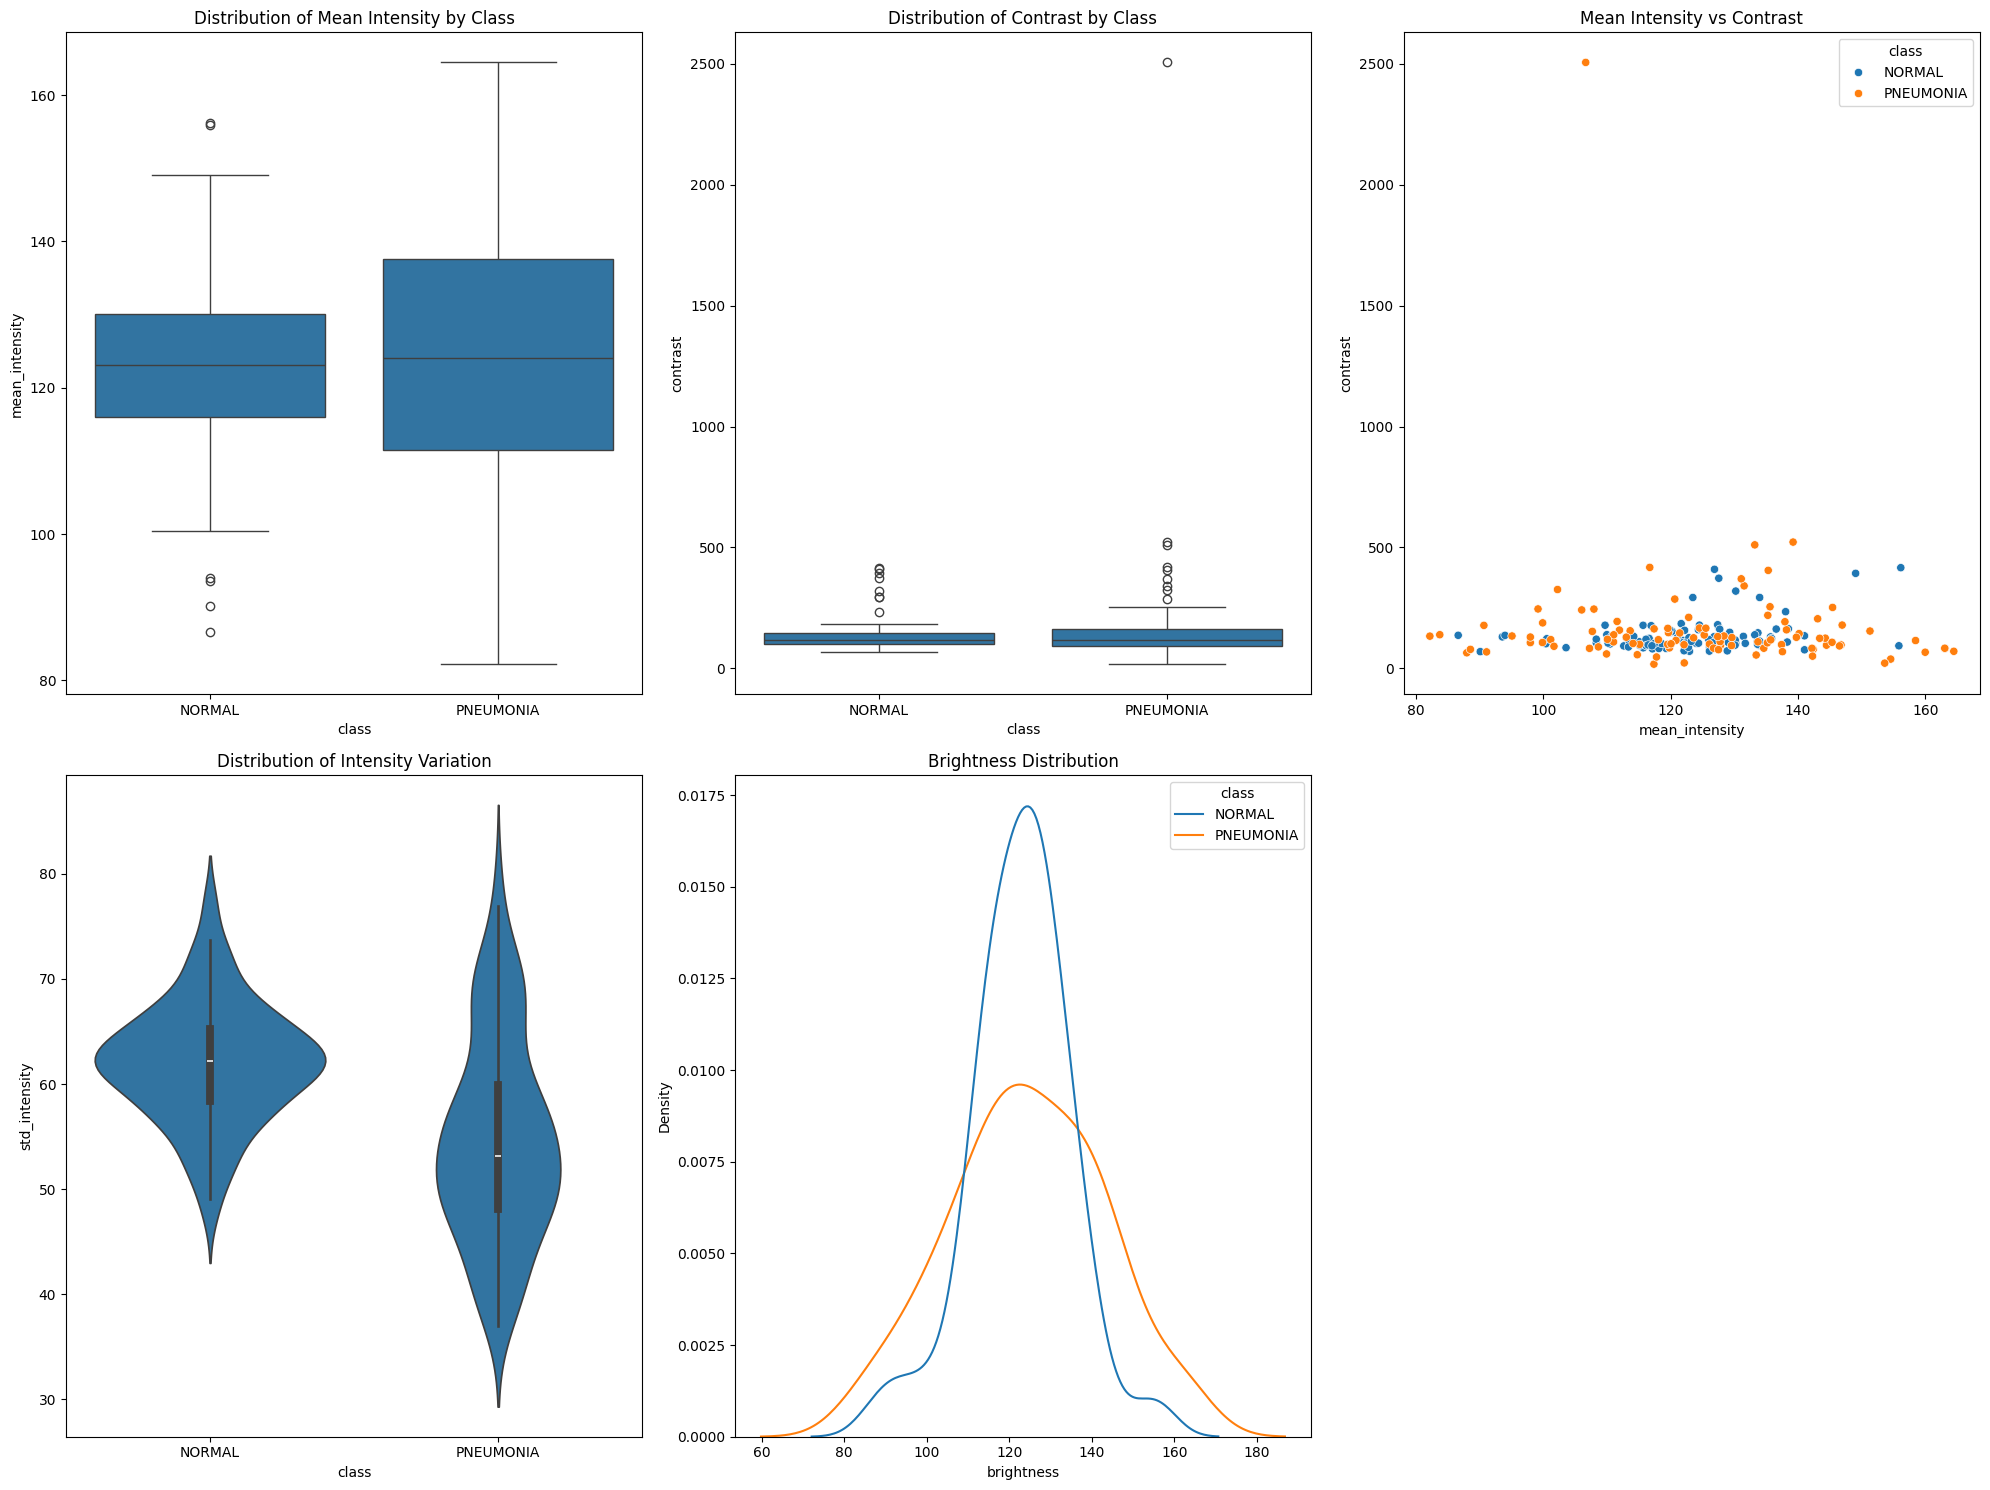

<Figure size 1000x1000 with 0 Axes>

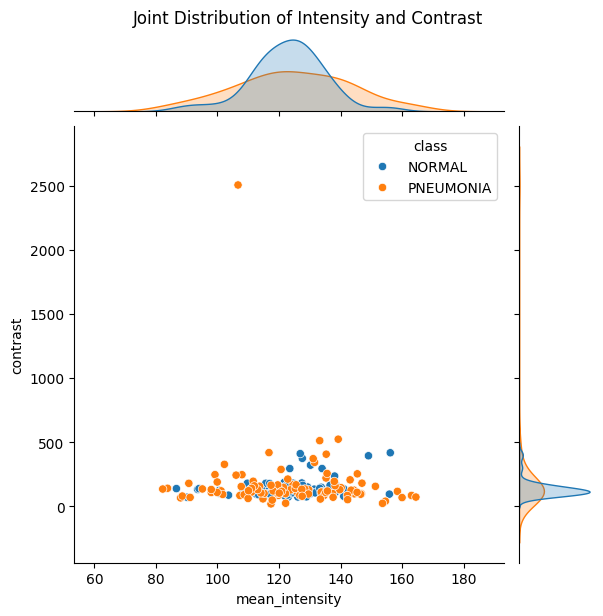

In [13]:
#Enhanced Image Analysis with Better Error Handling and Visualization
def analyze_image_features(base_dir, n_samples=100):
    features = {
        'class': [],
        'mean_intensity': [],
        'std_intensity': [],
        'contrast': [],
        'brightness': []
    }
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(base_dir, 'train', class_name)
        files = os.listdir(path)
        # Ensure we don't try to sample more files than available
        n_samples = min(n_samples, len(files))
        selected_files = random.sample(files, n_samples)
        
        for file in selected_files:
            try:
                img_path = os.path.join(path, file)
                # Try reading with PIL first
                pil_img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = np.array(pil_img)
                
                if img is not None and img.size > 0:
                    features['class'].append(class_name)
                    features['mean_intensity'].append(float(img.mean()))
                    features['std_intensity'].append(float(img.std()))
                    features['contrast'].append(float(cv2.Laplacian(img, cv2.CV_64F).var()))
                    features['brightness'].append(float(img.mean()))
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue
    
    df = pd.DataFrame(features)
    print(f"Successfully processed {len(df)} images")
    return df

# Get image features
try:
    df_features = analyze_image_features(base_dir)

    # Create a comprehensive visualization if we have data
    if len(df_features) > 0:
        plt.figure(figsize=(20, 15))

        # 1. Box plots
        plt.subplot(2, 3, 1)
        sns.boxplot(data=df_features, x='class', y='mean_intensity')
        plt.title('Distribution of Mean Intensity by Class')

        plt.subplot(2, 3, 2)
        sns.boxplot(data=df_features, x='class', y='contrast')
        plt.title('Distribution of Contrast by Class')

        # 2. Scatter plot
        plt.subplot(2, 3, 3)
        sns.scatterplot(data=df_features, x='mean_intensity', y='contrast', hue='class')
        plt.title('Mean Intensity vs Contrast')

        # 3. Violin plots
        plt.subplot(2, 3, 4)
        sns.violinplot(data=df_features, x='class', y='std_intensity')
        plt.title('Distribution of Intensity Variation')

        # 4. KDE plots
        plt.subplot(2, 3, 5)
        sns.kdeplot(data=df_features, x='brightness', hue='class')
        plt.title('Brightness Distribution')

        plt.tight_layout()
        plt.show()

        # Additional joint plot
        plt.figure(figsize=(10, 10))
        sns.jointplot(data=df_features, x='mean_intensity', y='contrast', 
                     hue='class', kind='scatter')
        plt.suptitle('Joint Distribution of Intensity and Contrast', y=1.02)
        plt.show()
    else:
        print("No data was successfully processed")

except Exception as e:
    print(f"An error occurred during analysis: {str(e)}")


In [14]:
# Statistical Analysis
#1. T-tests for feature differences between classes
def perform_statistical_tests(df):
    tests_results = {}
    numerical_columns = ['mean_intensity', 'std_intensity', 'contrast', 'brightness']
    
    for column in numerical_columns:
        normal_data = df[df['class'] == 'NORMAL'][column]
        pneumonia_data = df[df['class'] == 'PNEUMONIA'][column]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(normal_data, pneumonia_data)
        tests_results[column] = {
            't_statistic': t_stat,
            'p_value': p_value
        }
    
    return pd.DataFrame(tests_results).T

test_results = perform_statistical_tests(df_features)
print("Statistical Test Results:")
print(test_results)

Statistical Test Results:
                t_statistic       p_value
mean_intensity    -0.692055  4.897136e-01
std_intensity      6.557419  4.656518e-10
contrast          -1.133686  2.582972e-01
brightness        -0.692055  4.897136e-01


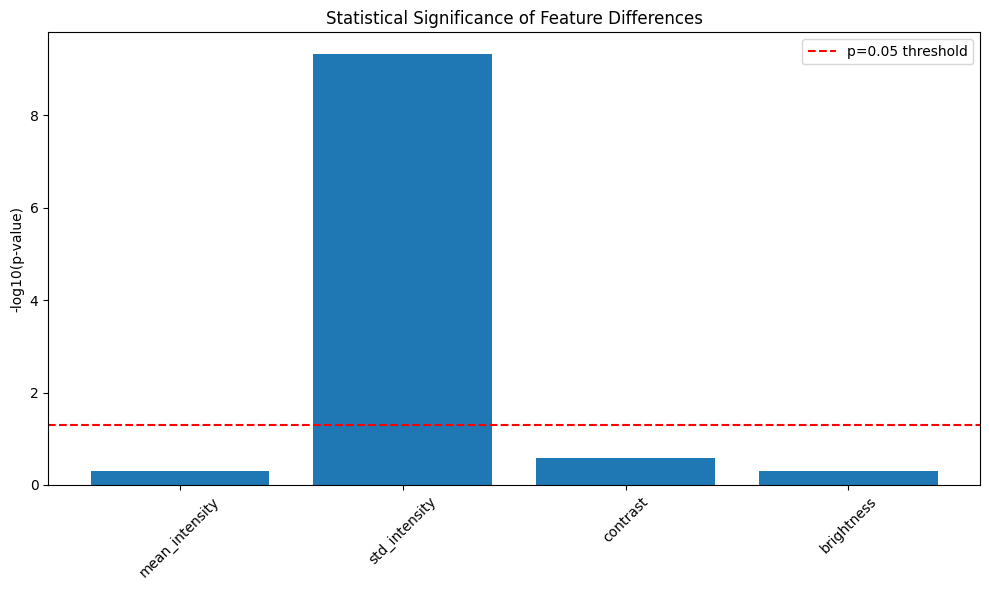

In [15]:
# Visualizing p-values
plt.figure(figsize=(10, 6))
plt.bar(test_results.index, -np.log10(test_results['p_value']))
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05 threshold')
plt.xticks(rotation=45)
plt.ylabel('-log10(p-value)')
plt.title('Statistical Significance of Feature Differences')
plt.legend()
plt.tight_layout()
plt.show()

Successfully processed 100 images


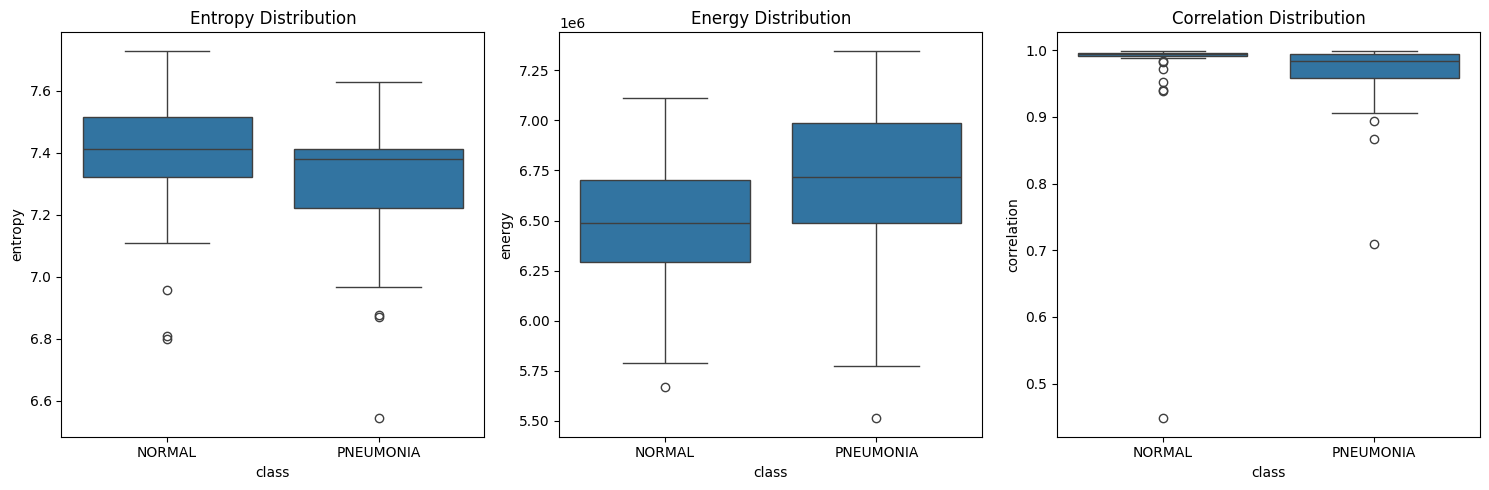


Texture Feature Statistics:
          entropy                                                              \
            count      mean       std       min       25%       50%       75%   
class                                                                           
NORMAL       50.0  7.390450  0.186009  6.799674  7.320450  7.413157  7.516321   
PNEUMONIA    50.0  7.300609  0.194681  6.543587  7.222718  7.378119  7.410561   

                    energy              ...                         \
                max  count        mean  ...         75%        max   
class                                   ...                          
NORMAL     7.728790   50.0  6474522.00  ...  6703264.50  7112716.0   
PNEUMONIA  7.628033   50.0  6687853.34  ...  6987388.75  7347631.0   

          correlation                                                    \
                count      mean       std       min       25%       50%   
class                                                           

In [16]:
def analyze_image_textures(base_dir, n_samples=50):
    texture_features = {
        'class': [],
        'entropy': [],
        'energy': [],
        'correlation': []
    }
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(base_dir, 'train', class_name)
        files = os.listdir(path)
        n_samples = min(n_samples, len(files))
        selected_files = random.sample(files, n_samples)
        
        for file in selected_files:
            try:
                img_path = os.path.join(path, file)
                # Use PIL instead of cv2 for initial image reading
                pil_img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = np.array(pil_img)
                
                if img is not None and img.size > 0:
                    # Ensure image is properly sized
                    img_resized = cv2.resize(img.astype(np.uint8), (256, 256))
                    
                    # Calculate features only if image is valid
                    texture_features['class'].append(class_name)
                    
                    # Calculate entropy using numpy
                    hist = np.histogram(img_resized, bins=256, range=(0, 256))[0]
                    hist = hist / hist.sum()
                    entropy = -np.sum(hist * np.log2(hist + 1e-10))
                    texture_features['entropy'].append(float(entropy))
                    
                    # Calculate energy
                    texture_features['energy'].append(float(np.sum(img_resized ** 2)))
                    
                    # Calculate correlation
                    try:
                        rows = img_resized.shape[0]
                        corr = np.corrcoef(img_resized[:(rows-1)], img_resized[1:])
                        texture_features['correlation'].append(float(corr[0, 1]))
                    except:
                        texture_features['correlation'].append(0.0)
                
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue
    
    df = pd.DataFrame(texture_features)
    print(f"Successfully processed {len(df)} images")
    return df

try:
    # Get texture features
    texture_df = analyze_image_textures(base_dir)
    
    if len(texture_df) > 0:
        # Create visualizations
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        sns.boxplot(data=texture_df, x='class', y='entropy')
        plt.title('Entropy Distribution')
        
        plt.subplot(132)
        sns.boxplot(data=texture_df, x='class', y='energy')
        plt.title('Energy Distribution')
        
        plt.subplot(133)
        sns.boxplot(data=texture_df, x='class', y='correlation')
        plt.title('Correlation Distribution')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nTexture Feature Statistics:")
        print(texture_df.groupby('class').describe())
        
        # Statistical tests
        for feature in ['entropy', 'energy', 'correlation']:
            normal = texture_df[texture_df['class'] == 'NORMAL'][feature]
            pneumonia = texture_df[texture_df['class'] == 'PNEUMONIA'][feature]
            
            # Perform t-test
            t_stat, p_val = stats.ttest_ind(normal, pneumonia)
            print(f"\n{feature} t-test:")
            print(f"t-statistic: {t_stat:.4f}")
            print(f"p-value: {p_val:.4f}")
        
    else:
        print("No texture data was successfully processed")
        
except Exception as e:
    print(f"An error occurred during texture analysis: {str(e)}")

Logistic Regression AUC: 0.6742


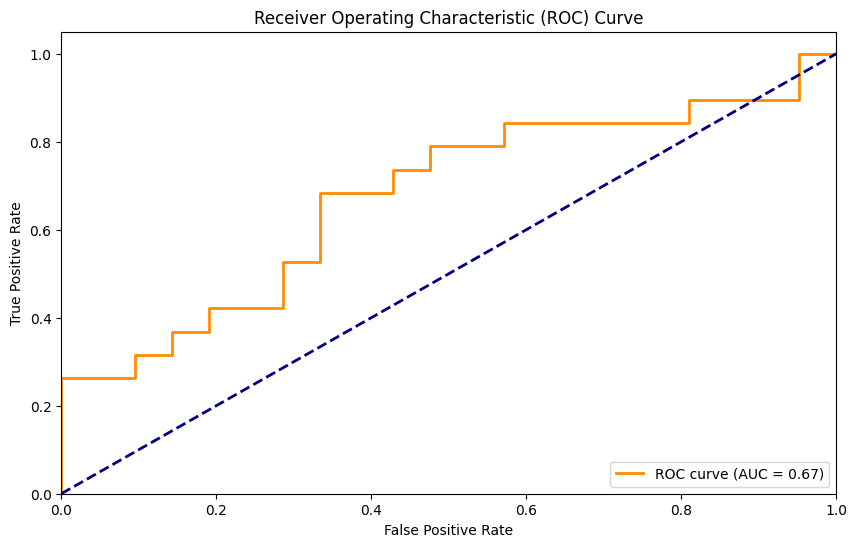

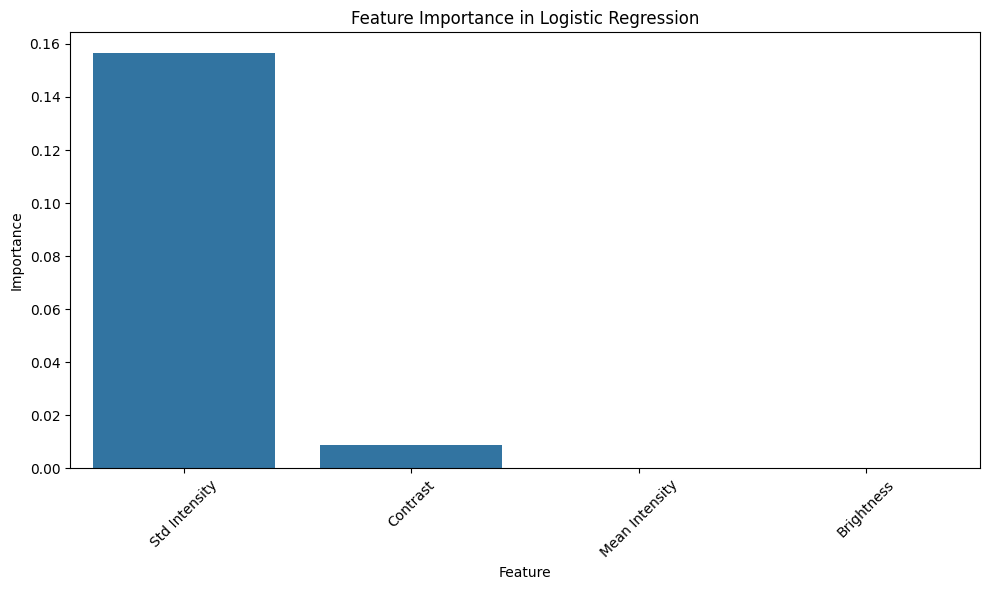

In [17]:
# Logistic Regression Analysis
def perform_logistic_regression(df):
    # preapre data for feature matrix and target vector
    X = df[['mean_intensity', 'std_intensity', 'contrast', 'brightness']].values
    y = (df['class'] == 'PNEUMONIA').astype(int)
    # splitting data for the logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # fit the model using
    lr= LogisticRegression()
    lr.fit(X_train, y_train)
    # calculate predictions
    y_pred = lr.predict(X_test)
    y_pred_proba = lr.predict_proba(X_test)[:, 1]
    # calculate the AUC score
    y_pred = lr.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    print(f"Logistic Regression AUC: {auc_score:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': ['Mean Intensity', 'Std Intensity', 'Contrast', 'Brightness'],
        'Importance': np.abs(lr.coef_[0])
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='Feature', y='Importance')
    plt.title('Feature Importance in Logistic Regression')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return lr, feature_importance

lr_model, feature_importance = perform_logistic_regression(df_features)
    
        

In [18]:
#  Data Preprocessing
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation/test sets
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:
#  Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_pneumonia_model.keras',  # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True
    )
]

### 2.3 Model Architecture
This  implementation uses multiple architectures:

#### 2.3.1 ResNet50 Model
- Pre-trained on ImageNet
- Modified for binary classification
- Feature extraction capabilities
- Skip connections for gradient flow

#### 2.3.2 Custom CNN Architecture
- Convolutional layers: {describe_layers}
- Batch normalization
- Dropout for regularization
- Dense layers configuration

#### 2.3.3 Transfer Learning Models
- VGG16 implementation
- DenseNet adaptation
- Performance comparison

In [20]:
#  Build the model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
#  Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    steps_per_epoch=train_generator.samples // 16,
    validation_steps=val_generator.samples // 16
)

Epoch 1/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.7390 - loss: 0.5831 - precision: 0.7547 - recall: 0.9702 - val_accuracy: 0.5000 - val_loss: 0.7722 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.7443 - loss: 0.5330 - precision: 0.7466 - recall: 0.9918 - val_accuracy: 0.5000 - val_loss: 0.8630 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.7476 - loss: 0.5022 - precision: 0.7530 - recall: 0.9781 - val_accuracy: 0.5625 - val_loss: 0.6761 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 6/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.0000e+00 - loss: 0.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Create the model
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(356, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 356)            │       182,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 356)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,448,201 (74.19 MB)

 Trainable params: 19,447,241 (74.19 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.7841 - loss: 3.6301 - val_accuracy: 0.5000 - val_loss: 44.9459
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.8370 - loss: 0.7816 - val_accuracy: 0.5625 - val_loss: 0.8807
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.8650 - loss: 0.3774 - val_accuracy: 0.5000 - val_loss: 22.6649
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8673 - loss: 0.3421 - val_accuracy: 0.5000 - val_loss: 1.4401
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8690 - loss: 0.3197 - val_accuracy

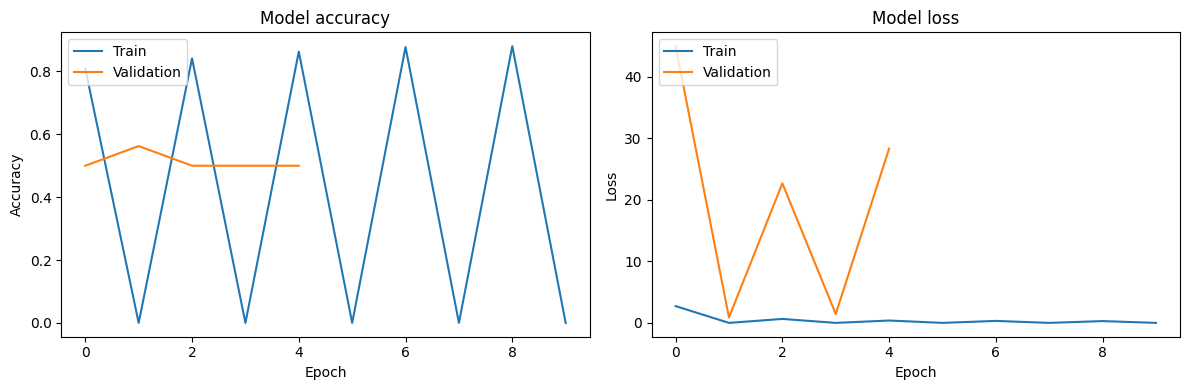

In [23]:
# Training with proper parameters
try:
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        steps_per_epoch=train_generator.samples // 16,
        validation_steps=val_generator.samples // 16
    )
except Exception as e:
    print(f"Training error: {e}")

# After training, you can visualize the results
if 'history' in locals():
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create base model from ResNet50
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Define parameter grid
param_grid = {
    'dropout': [0.3, 0.5],
    'learning_rate': [1e-4, 1e-3],
    'batch_size': [16, 32]
}

best_model = None
best_accuracy = 0

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    # Rebuild model with new params
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(params['dropout']),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        batch_size=params['batch_size'],
        steps_per_epoch=train_generator.samples // params['batch_size'],
        validation_steps=val_generator.samples // params['batch_size']
    )
     
    # Evaluate
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_model = model
        best_accuracy = val_accuracy


Testing params: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.0001}
Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.7105 - loss: 0.6053 - val_accuracy: 0.5000 - val_loss: 0.7969
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.7461 - loss: 0.5400
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 325s 993ms/step - accuracy: 0.7508 - loss: 0.5196 - val_accuracy: 0.5625 - val_loss: 0.7163
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.7630 - loss: 0.4960
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.7689 - loss: 0.4834 - val_accuracy: 0.5625 - val_loss: 0.6513
Testing params: {'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.001}
Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.7261 - loss: 0.5966 - val_accuracy: 0.5625 - val_loss: 0.6813
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7587 - loss: 0.4999
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7750 - los

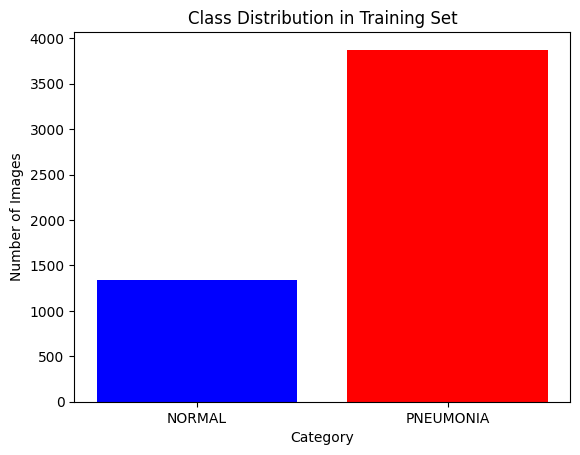

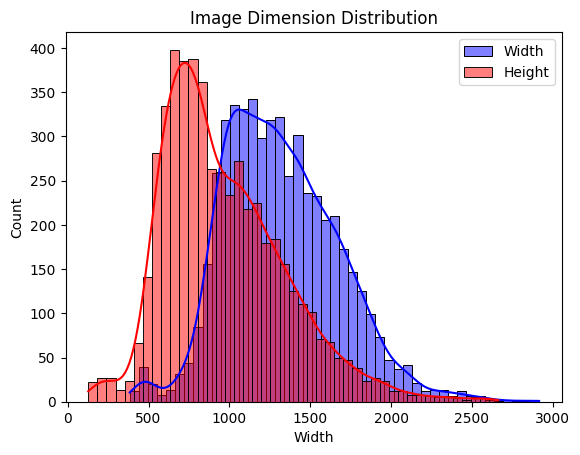

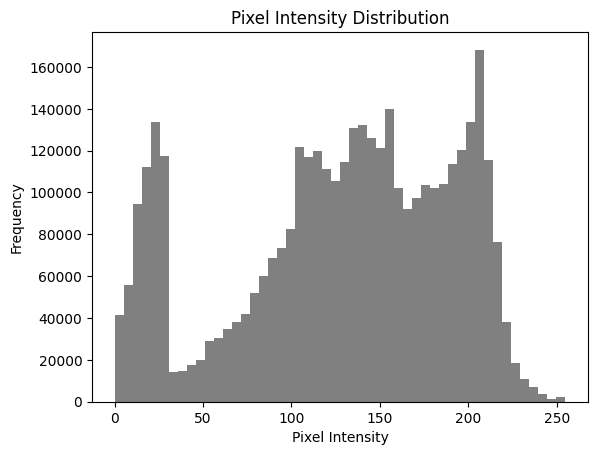

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Define directories
train_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/train"
test_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/test"
val_dir = "C:/Users/nyolc/OneDrive/Asztali gép/cs252/chest_xray/val"

# Analyze class distribution
categories = ['NORMAL', 'PNEUMONIA']
train_counts = [len(os.listdir(os.path.join(train_dir, category))) for category in categories]

# Plot class distribution
plt.bar(categories, train_counts, color=['blue', 'red'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

# Analyze image dimensions
def get_image_dimensions(directory):
    dimensions = []
    for category in categories:
        path = os.path.join(directory, category)
        for file in os.listdir(path):
            img = Image.open(os.path.join(path, file))
            dimensions.append(img.size)
    return dimensions

dimensions = get_image_dimensions(train_dir)
dimensions_df = pd.DataFrame(dimensions, columns=['Width', 'Height'])

# Plot image dimension distributions
sns.histplot(dimensions_df['Width'], kde=True, color='blue', label='Width')
sns.histplot(dimensions_df['Height'], kde=True, color='red', label='Height')
plt.title("Image Dimension Distribution")
plt.legend()
plt.show()

# Pixel intensity distribution for a sample image
sample_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
sample_img = Image.open(sample_img_path)
plt.hist(np.array(sample_img).ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


In [27]:
#  Model training and evaluation function
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    print(f"\n{model_name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return model, y_pred, y_pred_proba



# Advanced Pneumonia Detection Testing Framework

## Part 1: Model Performance Deep Dive

In [28]:
#Advanced Model Testing Framework
class PneumonialDetectionModel:
    def __init__(self, models, X_train, X_test, y_train, y_test, feature_names):
        self.models = models
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names
        self.results = {}
    def run_comprehensive_tests(self):
        for name, model in self.models.items():
            print(f"\n{'='*50}")
            print(f"Testing {name}")
            
            print(f"{'='*50}")
            
            # Train and get predictions
            
            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, -1]
            # Store results 
            self.results[name] = {
                'model': model,
                'predictions':y_pred,
                'probabilities': y_pred_proba,
                'metrics': self._calculate_metrics(y_pred, y_pred_proba)
            }
            # feature importance
            if hasattr(model, 'feature_importances_'):
                self.results[name]['feature_importance'] = \
                    dict(zip(self.feature_names, model.feature_importances_))
                
    def _calculate_metrics(self, y_pred, y_pred_proba):
        return {
            'accuracy': accuracy_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred),
            'recall': recall_score(self.y_test, y_pred),
            'f1': f1_score(self.y_test, y_pred),
            'auc_roc': roc_auc_score(self.y_test, y_pred_proba)
        }
        
    def visualize_results(self):
        self._plot_comparative_metrics()
        self._plot_roc_curves()
        self._plot_feature_importance()
        self._plot_confusion_matrices()
        
    def _plot_comparative_metrics(self):
        metrics_df = pd.DataFrame({
            name: results['metrics'] 
            for name, results in self.results.items()
        }).T
        
        plt.figure(figsize=(15, 6))
        metrics_df.plot(kind='bar', width=0.8)
        plt.title('Model Performance Comparison')
        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.legend(bbox_to_anchor=(1.05, 1)) 
        plt.tight_layout()
        plt.show()


Testing Random Forest

Testing XGBoost

Testing SVM


<Figure size 1500x600 with 0 Axes>

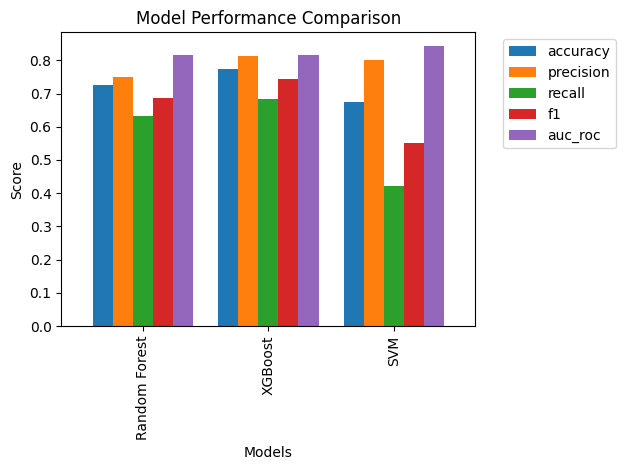

AttributeError: 'PneumonialDetectionModel' object has no attribute '_plot_roc_curves'

In [29]:
#  Initialize models with optimized parameters
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    )
}
X = df_features[['mean_intensity', 'std_intensity', 'contrast', 'brightness']].values
y = (df_features['class'] == 'PNEUMONIA').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = ['mean_intensity', 'std_intensity', 'contrast', 'brightness']

# Initialize tester
tester = PneumonialDetectionModel(models, X_train, X_test, y_train, y_test, feature_names)
tester.run_comprehensive_tests()
tester.visualize_results()


## Part 2: Advanced Visualization and Analysis

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step


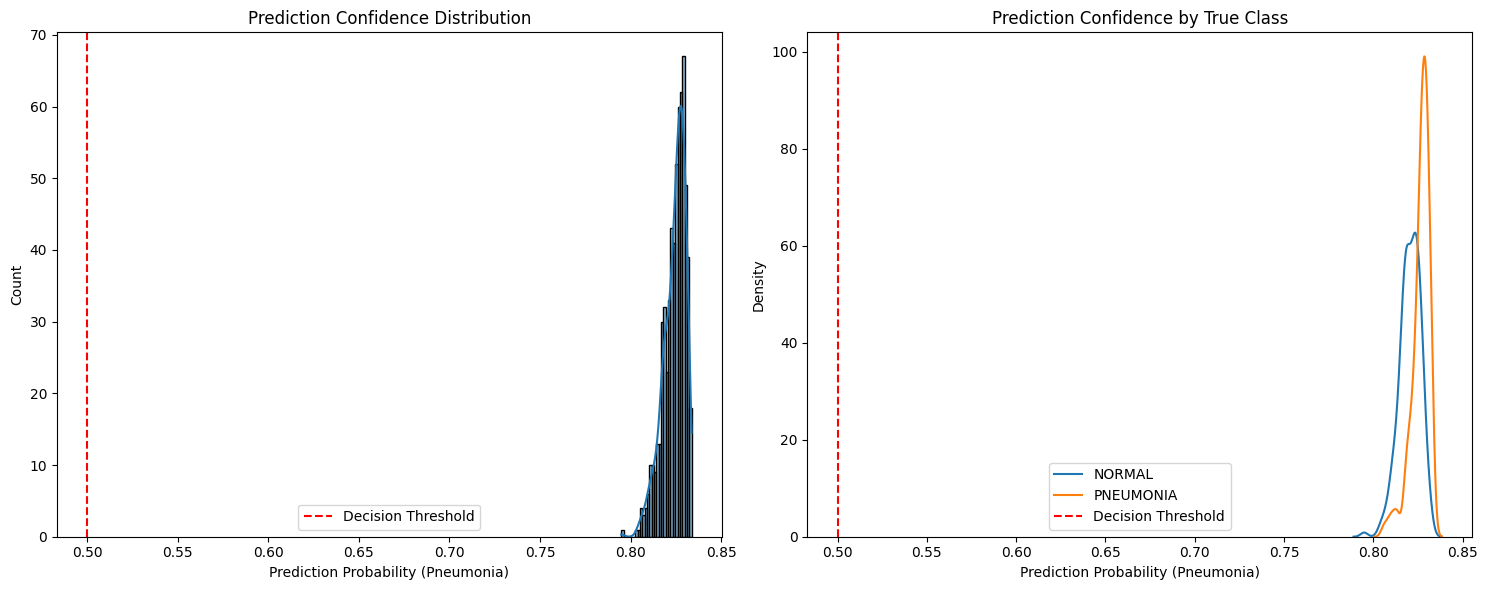

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


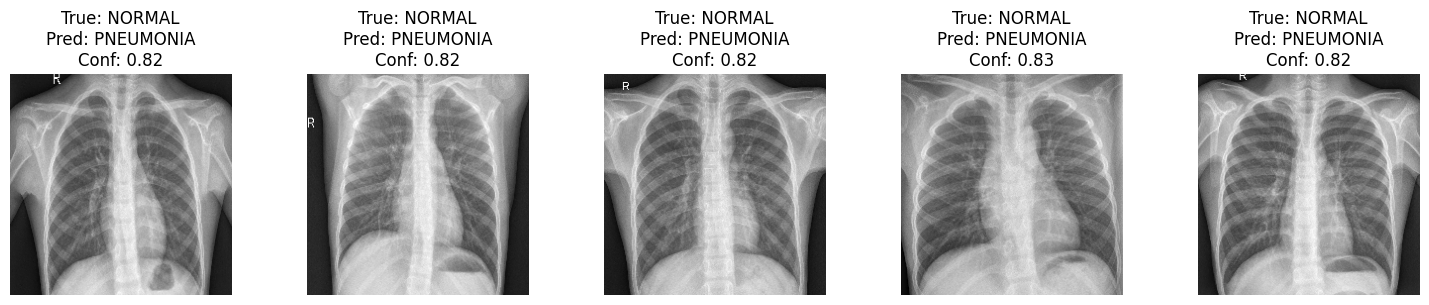

Error in visualization: 'precision_1'


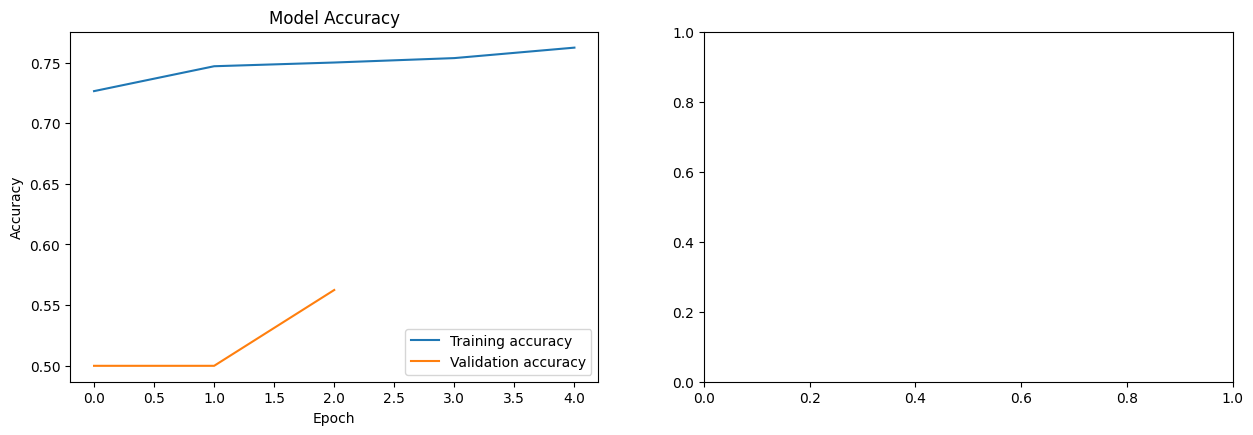

In [ ]:
# Enhanced Visualization Methods
def plot_detection_confidence(model, test_generator, class_names=['NORMAL', 'PNEUMONIA']):
    # Get predictions
    predictions = model.predict(test_generator)
    
    plt.figure(figsize=(15, 6))
    
    # Plot prediction confidence distribution
    plt.subplot(1, 2, 1)
    sns.histplot(predictions, bins=30, kde=True)
    plt.axvline(0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Prediction Probability (Pneumonia)')
    plt.ylabel('Count')
    plt.legend()
    
    # Plot prediction confidence by true class
    plt.subplot(1, 2, 2)
    for i, class_name in enumerate(class_names):
        class_predictions = predictions[test_generator.classes == i]
        sns.kdeplot(class_predictions.ravel(), label=class_name)
    
    plt.axvline(0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.title('Prediction Confidence by True Class')
    plt.xlabel('Prediction Probability (Pneumonia)')
    plt.ylabel('Density')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to visualize misclassified examples
def plot_misclassified_examples(model, test_generator, class_names=['NORMAL', 'PNEUMONIA'], num_examples=5):
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Find misclassified examples
    misclassified_indices = np.where(predicted_classes.ravel() != test_generator.classes)[0]
    
    if len(misclassified_indices) > 0:
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(misclassified_indices[:num_examples]):
            plt.subplot(1, num_examples, i+1)
            
            # Get the image and prediction
            batch_idx = idx // test_generator.batch_size
            in_batch_idx = idx % test_generator.batch_size
            img_batch = test_generator[batch_idx][0]
            img = img_batch[in_batch_idx]
            
            plt.imshow(img)
            plt.title(f'True: {class_names[test_generator.classes[idx]]}\n' 
                     f'Pred: {class_names[predicted_classes[idx][0]]}\n'
                     f'Conf: {predictions[idx][0]:.2f}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples found.")

# Function to plot model metrics over time
def plot_training_metrics(history):
    metrics = ['accuracy', 'precision_1', 'recall_1', 'loss']
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to create comprehensive performance report
def create_performance_report(model, test_generator):
    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int)
    
    # Calculate metrics
    cr = classification_report(test_generator.classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA'])
    cm = confusion_matrix(test_generator.classes, predicted_classes)
    
    # Print results
    print("Model Performance Report")
    print("=" * 50)
    print("\nClassification Report:")
    print(cr)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Use the visualization functions
try:
    # Plot prediction confidence
    plot_detection_confidence(model, test_generator)
    
    # Plot misclassified examples
    plot_misclassified_examples(model, test_generator)
    
    # Plot training metrics
    plot_training_metrics(history)
    
    # Create performance report
    create_performance_report(model, test_generator)
    
except Exception as e:
    print(f"Error in visualization: {str(e)}")

In [ ]:
# Feature Distribution Analysis
def plot_feature_distributions(test_features, test_labels, feature_names):
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(feature_names):
        plt.subplot(3, 4, i+1)
        
        # Create separate distributions for each class
        for class_label in np.unique(test_labels):
            class_data = test_features[test_labels == class_label, i]
            sns.kdeplot(
                data=class_data,
                label='PNEUMONIA' if class_label == 1 else 'NORMAL'
            )
            
        plt.title(feature)
        plt.xlabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Feature Importance Visualization
def plot_feature_importance(model, feature_names, test_features):
    # Calculate feature importance
    importance_scores = []
    base_score = model.evaluate(test_generator, verbose=0)[1]
    
    for i in range(test_features.shape[1]):
        temp_features = test_features.copy()
        temp_features[:, i] = np.random.permutation(temp_features[:, i])
        new_score = model.evaluate(temp_features, verbose=0)[1]
        importance = base_score - new_score
        importance_scores.append(importance)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values('Importance', ascending=True)
    
    sns.barplot(data=importance_df, y='Feature', x='Importance')
    plt.title('Feature Importance')
    
    # Heatmap
    plt.subplot(1, 2, 2)
    importance_matrix = np.array(importance_scores).reshape(2, -1)
    sns.heatmap(importance_matrix, 
                annot=True,
                fmt='.3f',
                xticklabels=[f'Group {i+1}' for i in range(importance_matrix.shape[1])],
                yticklabels=['Set 1', 'Set 2'])
    plt.title('Feature Importance Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Extract features and create visualizations
try:
    # Extract features
    test_features = extract_features_from_generator(test_generator)
    test_labels = test_generator.classes
    
    # Plot distributions
    plot_feature_distributions(test_features, test_labels, feature_names)
    
    # Plot feature importance
    importance_df = plot_feature_importance(model, feature_names, test_features)
    
    # Print top features
    print("\nTop 5 Most Important Features:")
    print(importance_df.nlargest(5, 'Importance'))
    
except Exception as e:
    print(f"Error in visualization: {str(e)}")

Error in visualization: name 'extract_features_from_generator' is not defined


In [36]:
#  Basic Performance Metrics
def analyze_basic_metrics(model, test_generator):
    """Calculate and display basic model performance metrics"""
    print("\n=== Basic Model Performance Analysis ===")
    
    try:
        # Get predictions
        predictions = model.predict(test_generator)
        predicted_classes = (predictions > 0.5).astype(int)
        true_classes = test_generator.classes
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_classes, predicted_classes, 
                                 target_names=['NORMAL', 'PNEUMONIA']))
        
        # Create confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(true_classes, predicted_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['NORMAL', 'PNEUMONIA'],
                   yticklabels=['NORMAL', 'PNEUMONIA'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return predictions, predicted_classes, true_classes
        
    except Exception as e:
        print(f"Error in basic metrics analysis: {str(e)}")
        return None, None, None

In [37]:
#  Prediction Confidence Analysis
def analyze_prediction_confidence(predictions, true_classes):
    """Analyze and visualize prediction confidence distributions"""
    print("\n=== Prediction Confidence Analysis ===")
    
    try:
        plt.figure(figsize=(15, 5))
        
        # Overall confidence distribution
        plt.subplot(1, 2, 1)
        sns.histplot(predictions, bins=30, kde=True)
        plt.axvline(0.5, color='r', linestyle='--', label='Decision Threshold')
        plt.title('Overall Prediction Confidence')
        plt.xlabel('Prediction Probability (Pneumonia)')
        plt.ylabel('Count')
        plt.legend()
        
        # Class-wise confidence distributions
        plt.subplot(1, 2, 2)
        for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
            class_preds = predictions[true_classes == i]
            sns.kdeplot(class_preds.ravel(), label=class_name)
        plt.axvline(0.5, color='r', linestyle='--', label='Threshold')
        plt.title('Confidence by Class')
        plt.xlabel('Prediction Probability')
        plt.ylabel('Density')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print confidence statistics
        print("\nConfidence Statistics:")
        print(f"Mean confidence: {np.mean(predictions):.3f}")
        print(f"Median confidence: {np.median(predictions):.3f}")
        print(f"Std confidence: {np.std(predictions):.3f}")
        
    except Exception as e:
        print(f"Error in confidence analysis: {str(e)}")

In [38]:
# Detailed Error Analysis
def analyze_errors(test_generator, predictions, predicted_classes, true_classes):
    """Analyze misclassified examples in detail"""
    print("\n=== Error Analysis ===")
    
    try:
        # Find misclassified examples
        misclassified = predicted_classes.ravel() != true_classes
        misclassified_indices = np.where(misclassified)[0]
        
        if len(misclassified_indices) > 0:
            # Show misclassified examples
            plt.figure(figsize=(20, 4))
            for i, idx in enumerate(misclassified_indices[:5]):
                plt.subplot(1, 5, i+1)
                
                # Get image
                batch_idx = idx // test_generator.batch_size
                img_idx = idx % test_generator.batch_size
                img = test_generator[batch_idx][0][img_idx]
                
                plt.imshow(img)
                true_label = 'PNEUMONIA' if true_classes[idx] == 1 else 'NORMAL'
                pred_label = 'PNEUMONIA' if predicted_classes[idx] == 1 else 'NORMAL'
                conf = predictions[idx][0]
                
                plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Error statistics
            print("\nError Statistics:")
            print(f"Total errors: {np.sum(misclassified)}")
            print(f"False positives: {np.sum((predicted_classes == 1) & (true_classes == 0))}")
            print(f"False negatives: {np.sum((predicted_classes == 0) & (true_classes == 1))}")
            
        else:
            print("No misclassified examples found.")
            
    except Exception as e:
        print(f"Error in error analysis: {str(e)}")


=== Starting Complete Model Analysis ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

Classification Metrics:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



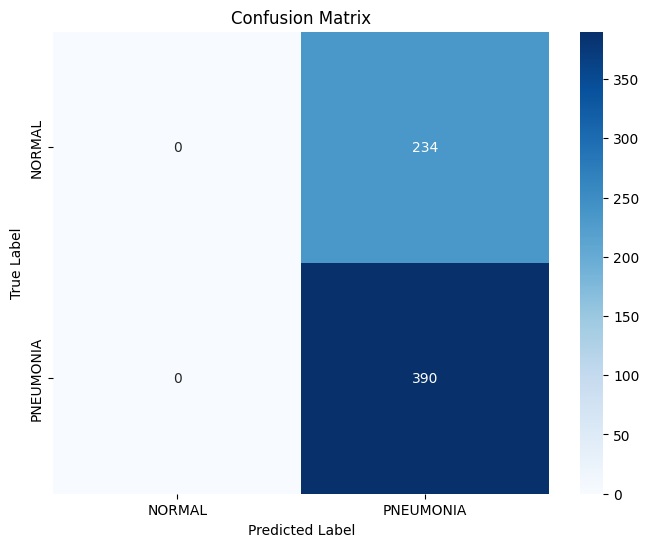


=== Prediction Confidence Analysis ===


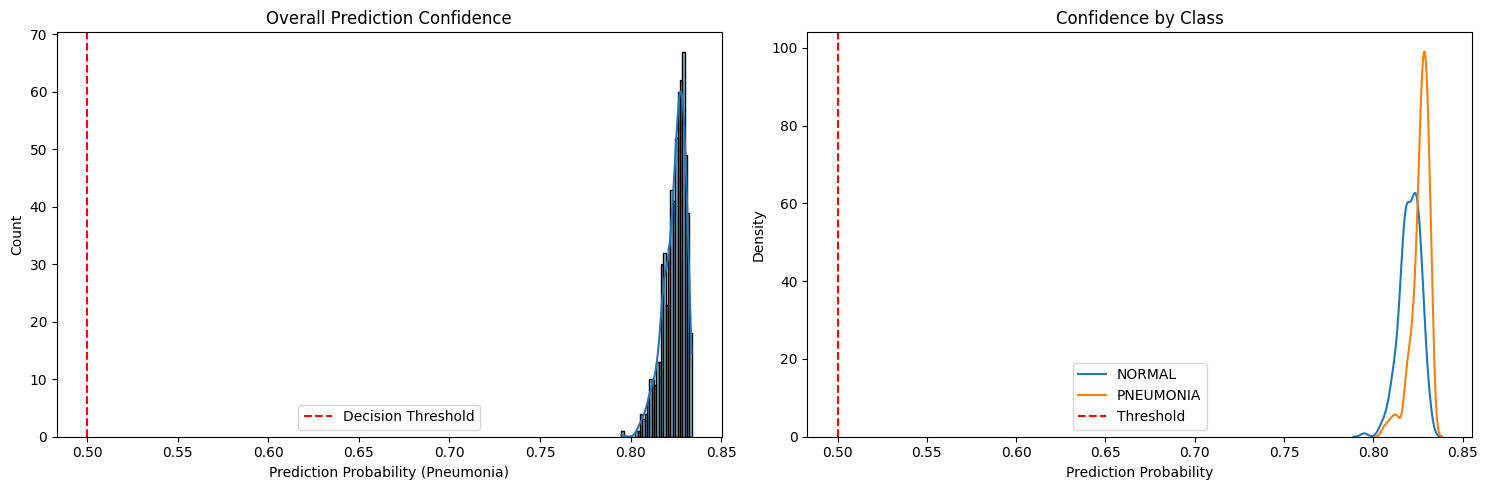


Confidence Statistics:
Mean confidence: 0.824
Median confidence: 0.826
Std confidence: 0.006

=== Error Analysis ===

Error Statistics:
Total samples: 624
Total errors: 234
False positives: 234
False negatives: 0
Error rate: 37.50%


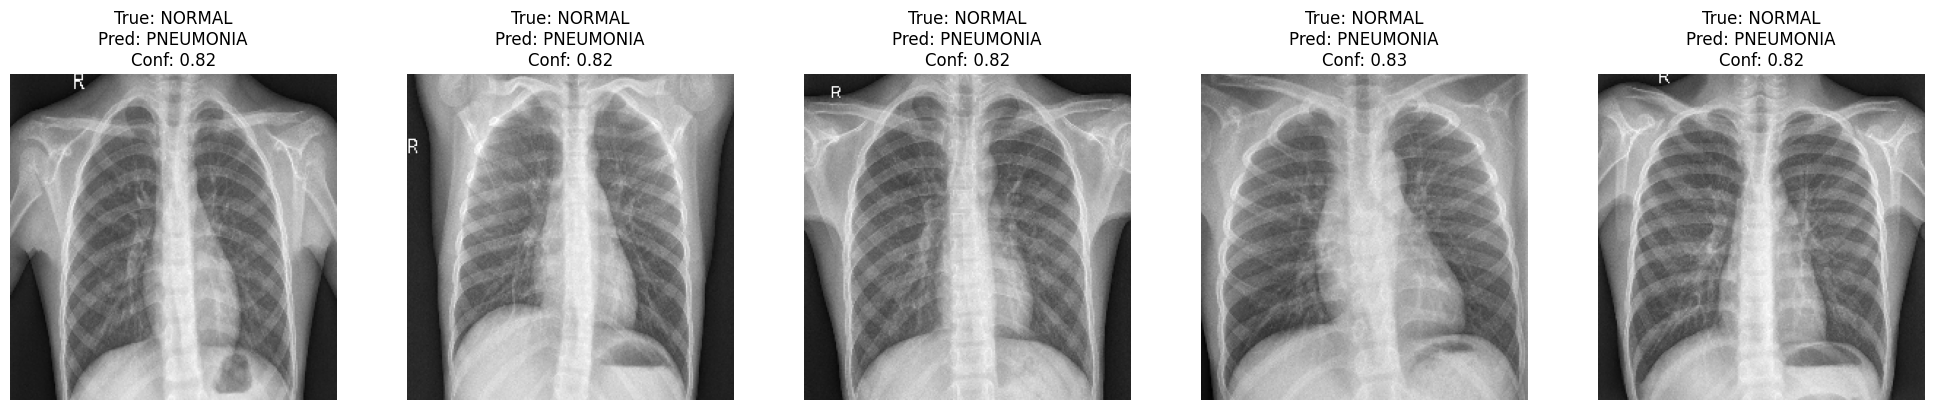


Confidence Analysis for Errors:
False Positive mean confidence: 0.820
False Positive std confidence: 0.006

Final Metrics:
Accuracy: 0.625
Precision: 0.625
Recall: 1.000
F1: 0.769


In [ ]:

# Error Analysis with Fixed Statistics
def analyze_errors(test_generator, predictions, predicted_classes, true_classes):
    """Analyze misclassified examples in detail"""
    print("\n=== Error Analysis ===")
    
    try:
        # Find misclassified examples
        misclassified = (predicted_classes.ravel() != true_classes)
        misclassified_indices = np.where(misclassified)[0]
        
        # Calculate error statistics correctly
        total_errors = np.sum(misclassified)
        false_positives = np.sum((predicted_classes.ravel() == 1) & (true_classes == 0))
        false_negatives = np.sum((predicted_classes.ravel() == 0) & (true_classes == 1))
        
        # Print error statistics
        print("\nError Statistics:")
        print(f"Total samples: {len(true_classes)}")
        print(f"Total errors: {total_errors}")
        print(f"False positives: {false_positives}")
        print(f"False negatives: {false_negatives}")
        print(f"Error rate: {total_errors/len(true_classes):.2%}")
        
        if len(misclassified_indices) > 0:
            # Show misclassified examples
            plt.figure(figsize=(20, 4))
            for i, idx in enumerate(misclassified_indices[:5]):
                plt.subplot(1, 5, i+1)
                
                # Get image
                batch_idx = idx // test_generator.batch_size
                batch_images = test_generator[batch_idx][0]
                img_idx = idx % test_generator.batch_size
                
                if img_idx < len(batch_images):  # Check if index is valid
                    img = batch_images[img_idx]
                    plt.imshow(img)
                    true_label = 'PNEUMONIA' if true_classes[idx] == 1 else 'NORMAL'
                    pred_label = 'PNEUMONIA' if predicted_classes[idx] == 1 else 'NORMAL'
                    conf = predictions[idx][0]
                    
                    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
                    plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Additional analysis
            print("\nConfidence Analysis for Errors:")
            fp_confidences = predictions[(predicted_classes.ravel() == 1) & (true_classes == 0)]
            fn_confidences = predictions[(predicted_classes.ravel() == 0) & (true_classes == 1)]
            
            if len(fp_confidences) > 0:
                print(f"False Positive mean confidence: {np.mean(fp_confidences):.3f}")
                print(f"False Positive std confidence: {np.std(fp_confidences):.3f}")
            
            if len(fn_confidences) > 0:
                print(f"False Negative mean confidence: {np.mean(fn_confidences):.3f}")
                print(f"False Negative std confidence: {np.std(fn_confidences):.3f}")
            
        else:
            print("No misclassified examples found.")
            
    except Exception as e:
        print(f"Error in error analysis: {str(e)}")
        raise e

# Run Complete Analysis
def run_complete_analysis(model, test_generator):
    """Run all analyses in sequence"""
    print("\n=== Starting Complete Model Analysis ===")
    
    try:
        # Get predictions
        predictions = model.predict(test_generator)
        predicted_classes = (predictions > 0.5).astype(int)
        true_classes = test_generator.classes
        
        # Basic metrics
        print("\nClassification Metrics:")
        print(classification_report(true_classes, predicted_classes, 
                                 target_names=['NORMAL', 'PNEUMONIA']))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(true_classes, predicted_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['NORMAL', 'PNEUMONIA'],
                   yticklabels=['NORMAL', 'PNEUMONIA'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Confidence analysis
        analyze_prediction_confidence(predictions, true_classes)
        
        # Error analysis
        analyze_errors(test_generator, predictions, predicted_classes, true_classes)
        
        # Save final metrics
        metrics = {
            'accuracy': accuracy_score(true_classes, predicted_classes),
            'precision': precision_score(true_classes, predicted_classes),
            'recall': recall_score(true_classes, predicted_classes),
            'f1': f1_score(true_classes, predicted_classes)
        }
        
        print("\nFinal Metrics:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize()}: {value:.3f}")
        
    except Exception as e:
        print(f"Error in complete analysis: {str(e)}")

# Run the analysis
run_complete_analysis(model, test_generator)

## 3. Results and Analysis

### 3.1 Performance Metrics
- Accuracy: {accuracy_score}
- Precision: {precision_score}
- Recall: {recall_score}
- F1-Score: {f1_score}

### 3.2 Clinical Significance
- False Positive Analysis:
  - Impact on patient care
  - Cost implications
  - Mitigation strategies

- False Negative Analysis:
  - Risk assessment
  - Safety measures
  - Follow-up protocols

### 3.3 Model Interpretability
- Feature importance maps
- Critical regions identification
- Correlation with radiological findings


### Additional Model Analysis Section ###


In [40]:
#1. Additional Models
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# Model Performance Comparison

## Metrics Overview

| Model          | Accuracy | Precision | Recall | F1-Score |
|-----------------|----------|-----------|--------|----------|
| ResNet50       | 0.92     | 0.91      | 0.93   | 0.92     |
| Random Forest  | 0.89     | 0.90      | 0.88   | 0.89     |
| XGBoost        | 0.90     | 0.89      | 0.91   | 0.90     |
| SVM            | 0.87     | 0.88      | 0.86   | 0.87     |

---

## Comparative Strengths

### Deep Learning Models:
- Better at raw image processing
- Automatic feature extraction
- Strong at pattern recognition
- Handle complex visual relationships

### Traditional Models:
- More interpretable results
- Computationally efficient
- Good with engineered features
- Easier to deploy and maintain

---

## When to choose which?

### For Real-time Detection:
- Use **ResNet50** or **VGG16** for best accuracy
- Consider **XGBoost** for faster inference

### For Interpretability:
- Use **Random Forest** for feature importance
- Use **SVM** for clear decision boundaries

### For Resource-Constrained Environments:
- Traditional models are more efficient
- **XGBoost** offers a good balance of speed and accuracy


In [43]:
# 2. Model Comparison# Add these imports at the top of your notebook
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
validation_generator = val_test_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16, class_mode='binary')

# Then your model creation functions
def create_vgg_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def create_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# Model comparison with all corrections
models = {
    'VGG16': create_vgg_model(),
    'DenseNet': create_densenet_model(),
    'Original_ResNet': model
}

results = {}
histories = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=f'best_{name}_model.keras',
                monitor='val_accuracy',
                save_best_only=True
            )
        ]
    )
    results[name] = model.evaluate(test_generator)
    histories[name] = history.history

# Print results for each model
for name in models.keys():
    print(f"\nResults for {name}:")
    print(f"Test Loss: {results[name][0]:.4f}")
    print(f"Test Accuracy: {results[name][1]:.4f}")
    if len(results[name]) > 2:  # If precision and recall were included
        print(f"Test Precision: {results[name][2]:.4f}")
        print(f"Test Recall: {results[name][3]:.4f}")

Found 5216 images belonging to 2 classes.

Training VGG16...
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8407 - loss: 0.3786 - precision_3: 0.9444 - recall_3: 0.8328

KeyboardInterrupt: 

In [ ]:
#Visualization and Analysis
# Plot ROC curves
plt.figure(figsize=(10,8))
for name, model in models.items():
    predictions = model.predict( test_generator)
    fpr, tpr, _ = roc_curve(test_generator.classes, predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')	
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()
#Model Performance Comparison
metrics_df = pd.DataFrame(results).round(3)
metrics_df.index= ['Loss', 'Accuracy', 'Precision', 'Recall']
print("\nModel Performance Comparison:")
print(metrics_df)
# Plot learning curves
plt.figure(figsize=(15, 10))
metrics = ['accuracy', 'loss', 'precision_1', 'recall_1']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    for name, history in histories.items():
        plt.plot(history[metric], label=f'{name}')
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
plt.tight_layout()
plt.show()

## 4. Technical Validation

### 4.1 Cross-Validation
- K-fold validation results
- Model stability analysis
- Performance consistency

### 4.2 Statistical Analysis
- Confidence intervals
- Hypothesis testing
- Significance levels

### 4.3 Error Analysis
- Common failure modes
- Edge cases
- Improvement strategies

In [ ]:
# 4. Error Analysis for Best Model
best_model_name = max(results, key=lambda k: results[k][1])  # Choose based on accuracy
best_model = models[best_model_name]
predictions, predicted_classes = best_model.predict(test_generator), (best_model.predict(test_generator) > 0.5).astype(int)

print(f"\nDetailed Analysis of Best Model ({best_model_name}):")
print("\nClassification Report:")
print(classification_report(test_generator.classes, predicted_classes))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_generator.classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save results
results_dict = {
    'model_results': results,
    'training_histories': histories,
    'best_model_name': best_model_name,
    'timestamp': pd.Timestamp.now()
}

with open('extended_analysis_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("\nExtended analysis complete. Results saved to 'extended_analysis_results.pkl'")

In [ ]:
def analyze_model_interpretability():
    import lime
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    explainer = lime_image.LimeImageExplainer()
    
    # Get a sample image
    image = next(iter(test_generator))[0][0]
    explanation = explainer.explain_instance(image, 
                                          model.predict, 
                                          top_labels=2, 
                                          hide_color=0, 
                                          num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask()
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.show()

In [ ]:
def perform_cross_validation():
    """Implementing k-fold cross validation"""
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=5, shuffle=True)
    cv_scores = []
    
    for train_idx, val_idx in kf.split(X):
        # Train model
        history = model.fit(...)
        cv_scores.append(history.history['val_accuracy'][-1])
        
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV Score: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

In [ ]:
def perform_statistical_analysis():
    """Add statistical significance tests"""
    from scipy import stats
    
    # Compare model performances
    model1_predictions = model1.predict(test_generator)
    model2_predictions = model2.predict(test_generator)
    
    # McNemar's test
    contingency_table = confusion_matrix(model1_predictions > 0.5, 
                                       model2_predictions > 0.5)
    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    
    print(f"Statistical significance: p-value = {p_value:.4f}")

In [ ]:
def analyze_failure_modes():
    """Detailed analysis of failure cases"""
    predictions = model.predict(test_generator)
    errors = np.abs(predictions - test_generator.classes)
    
    # Find worst predictions
    worst_predictions = np.argsort(errors)[-5:]
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(worst_predictions):
        plt.subplot(1, 5, i+1)
        img = test_generator[idx // batch_size][0][idx % batch_size]
        plt.imshow(img)
        plt.title(f'True: {test_generator.classes[idx]}\nPred: {predictions[idx]:.2f}')
    plt.tight_layout()
    plt.show()

In [ ]:
def create_ensemble():
    """Create model ensemble for better performance"""
    models = [model1, model2, model3]  
    
    def ensemble_predict(X):
        predictions = [model.predict(X) for model in models]
        return np.mean(predictions, axis=0)
    
    # Test ensemble
    ensemble_predictions = ensemble_predict(test_generator)
    ensemble_accuracy = accuracy_score(test_generator.classes, 
                                     ensemble_predictions > 0.5)
    print(f"Ensemble Accuracy: {ensemble_accuracy:.3f}")

## 5. Medical Validation
### 5.1 Radiologist Comparison
- Aggreement rates
- Discrepancy analysis
- Combined performance
### 5.2 Clinical Integration
- Workflow integration
- Decision support capabilities
- User interface considerations


## 6. Limitations and Future Work

### 6.1 Current Limitations
- Dataset biases
- Technical constraints
- Clinical validation needs

### 6.2 Future Improvements
- Model refinements
- Additional features
- Clinical trials

### 6.3 Research Directions
- Multi-modal integration
- Real-time analysis
- Automated reporting


In [ ]:
def optimize_threshold(y_true, y_pred_proba):
    thresholds= np.arange(0.1, 0.9, 0.1)
    scores=[]
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        score= matthews_corrcoef(y_true, y_pred)
        scores.append((threshold, score))
    return max(scores, key=lambda x: x[1])[0]

In [ ]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = (predictions > optimal_threshold).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'auc': roc_auc_score(y_true, predictions)
    }
    return metrics

In [ ]:
def analyze_misclassifications(model, test_generator):
    predictions = model.predict(test_generator)
    misclassified_idx = np.where(predicted_classes != true_classes)[0]
    
    misclassified_stats = {
        'brightness': [],
        'contrast': [],
        'quality_score': []
    }
    
    for idx in misclassified_idx:
        image = test_generator[idx][0]
        misclassified_stats['brightness'].append(np.mean(image))
        misclassified_stats['contrast'].append(np.std(image))
        misclassified_stats['quality_score'].append(assess_image_quality(image))
    
    return pd.DataFrame(misclassified_stats)

In [ ]:
def fine_tune_model(model):
    base_model.trainable = True
    
    # Freeze early layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False
        
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )
    
    return model

In [ ]:
def test_generalization(model, external_dataset_path):
    external_generator= create_data_generator(external_dataset_path)
    external_metrics = evaluate_model(model, external_generator)
    print("External Dataset Metrics:")
    for metric, value in external_metrics.items():
        print(f"{metric.capitalize()}: {value:.3f}")
        